# General librarires

In [2]:
# Importing the numpy library (for arrays operations)
# Importing the pandas library (for data analysis)
# Importing the matplotlib.pyplot interface (for MATLAB-like plots)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Dataset preparation
We start by loading the dataset (csv file) we shall work with. We use Netflix stock price from 04/04/2013 to 04/04/2022 retrieved from <b>investing.com</b>:<br>
https://www.investing.com/equities/netflix,-inc.-historical-data

In [3]:
# Storing the data in DataFrame "df", sorted by date in ascending order

df = pd.read_csv('NFLX Historical Data.csv')
df = df[::-1]
df

,Date,Price,Open,High,Low,Vol.,Change %
2268,"Apr 04, 2013",23.81,23.91,24.30,23.40,34.46M,-1.81%
2267,"Apr 05, 2013",23.52,23.36,24.36,23.22,32.52M,-1.22%
2266,"Apr 08, 2013",23.29,23.69,23.76,22.71,31.76M,-0.98%
2265,"Apr 09, 2013",24.19,23.36,24.48,23.15,34.08M,3.86%
2264,"Apr 10, 2013",23.72,24.00,24.21,23.56,29.73M,-1.94%
...,...,...,...,...,...,...,...
4,"Mar 29, 2022",391.82,384.39,396.50,380.33,5.81M,3.52%
3,"Mar 30, 2022",381.47,389.55,392.70,378.63,4.00M,-2.64%
2,"Mar 31, 2022",374.59,383.59,384.00,373.61,4.12M,-1.80%
1,"Apr 01, 2022",373.47,376.80,380.87,368.50,4.64M,-0.30%


In [4]:
# Storing "Price" values of "df" in a numpy array "arr", and reshaping it into a vertical array

arr = df['Open'].values
arr = arr.reshape(-1, 1)
arr.shape

(2269, 1)

In [5]:
# Splitting the data into a training set stored in array "arr_train" (first 80% of the rows of "arr")
# And a test set stored in array "arr_test" (last 20% of the rows of "arr")
# Storing in list "dates" the dates corresponding to "arr_test"

arr_train = arr[:int(arr.shape[0]*0.8)]
arr_test = arr[int(arr.shape[0]*0.8):]
dates = df['Date'].tolist()[int(arr.shape[0]*0.8):]

print('Shape of arr_train:', arr_train.shape)
print('Shape of arr_train:', arr_test.shape)
print('Length of dates:', len(dates))

Shape of arr_train: (1815, 1)
Shape of arr_train: (454, 1)
Length of dates: 454


In [6]:
# Importing the estimator "MinMaxScaler" from the sklearn.preprocessing module
# (to rescale data to a given range, typically the interval [0,1])
# See https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

from sklearn.preprocessing import MinMaxScaler

# Rescaling "arr_train" and "arr_test" to the interval [0,1]

scaler = MinMaxScaler()
arr_train = scaler.fit_transform(arr_train)
arr_test = scaler.fit_transform(arr_test)
print('Rescaled arr_train:\n', arr_train)

Rescaled arr_train:
 [[1.27642786e-03]
 [0.00000000e+00]
 [7.65856715e-04]
 ...
 [9.41400357e-01]
 [9.23483952e-01]
 [9.34438024e-01]]


In [7]:
# Defining a function "create_data" which creates two numpy arrays x, y from input array "arr" and integer "n"
# The 1D numpy array y contains all the last values of arr, starting from the n-th value
# The 2D numpy array x contains all the lists of last n values of arr

def create_data(arr, n):
    x, y = [], []
    for i in range(n, arr.shape[0]):
        x.append(arr[i-n: i, 0])
        y.append(arr[i, 0])
    x, y = np.array(x), np.array(y)
    return x,y 

In [8]:
# Using the function "create_data" with n=50 to create the training and test datasets for the LSTM model
# Storing in "dates" the set of dates corresponding to "y_test"

n = 50
x_train, y_train = create_data(arr_train, n)
x_test, y_test = create_data(arr_test, n)
dates = dates[n:]

print('Shape of x_train:', x_train.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of x_test:', x_test.shape)
print('Shape of y_test:', y_test.shape)
print('Length of dates:', len(dates))

Shape of x_train: (1765, 50)
Shape of y_train: (1765,)
Shape of x_test: (404, 50)
Shape of y_test: (404,)
Length of dates: 404


# RNN model

In [9]:
# Importing the "Sequential" class from the keras.models API (to group a linear stack of layers into a model)
# Importing the "load_model" function from the keras.models API (to load a model saved via model.save())
# Importing the "LSTM" class from the keras.layers API (to load the long short-term memory layer to be used)
# Importing the "Dense" class from the keras.layers API (to load the regular densely-connected NN layer to be used)
# Importing the "Dropout" class from the keras.layers API (to apply dropout to the input)

# See https://keras.io/api/models/sequential/
# See https://keras.io/api/models/model_saving_apis/#loadmodel-function
# See https://keras.io/api/layers/recurrent_layers/lstm/
# See https://keras.io/api/layers/core_layers/dense/
# See https://keras.io/api/layers/regularization_layers/dropout/

from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout

In [10]:
# Defining a RNN model with n days of stock prices as input to predict the stock price at day n+1

# Adding a last dense layer providing the prediction of the next day stock price

model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(n, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [11]:
# Printing a summary of the RNN model

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 96)            37632     
                                                                 
 dropout (Dropout)           (None, 50, 96)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 96)            74112     
                                                                 
 dropout_1 (Dropout)         (None, 50, 96)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50, 96)            74112     
                                                                 
 dropout_2 (Dropout)         (None, 50, 96)            0         
                                                                 
 lstm_3 (LSTM)               (None, 96)                7

In [12]:
# Reshaping "x_train" and "x_test" into the 3D format needed for the LSTM input layer
# Number of rows, size of the sample and number of features (here 1 for "Price" values)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

print('New shape of x_train:', x_train.shape)
print('New shape of x_test:', x_test.shape)

New shape of x_train: (1765, 50, 1)
New shape of x_test: (404, 50, 1)


In [13]:
# Compiling the model with mean square between labels and predictions as quantity to minimise during training
# Using "adam" as optimizer (a type of stochastic gradient descent)
# See https://keras.io/api/optimizers/adam/

model.compile(loss='mean_squared_error', optimizer='adam')

In [14]:
# Training the model with a given number of epochs and batch size
# Saving the model's attributes in a HDF5 file
# See https://www.tensorflow.org/guide/keras/save_and_serialize#keras_h5_format

model.fit(x_train, y_train, epochs=50, batch_size=32)
model.save('stock_price.h5')

Epoch 1/50
56/56 [==============================] - 8s 65ms/step - loss: 0.0132
Epoch 2/50
56/56 [==============================] - 3s 62ms/step - loss: 0.0032
Epoch 3/50
56/56 [==============================] - 3s 61ms/step - loss: 0.0026
Epoch 4/50
56/56 [==============================] - 3s 62ms/step - loss: 0.0027
Epoch 5/50
56/56 [==============================] - 4s 63ms/step - loss: 0.0034
Epoch 6/50
56/56 [==============================] - 4s 69ms/step - loss: 0.0026
Epoch 7/50
56/56 [==============================] - 4s 75ms/step - loss: 0.0025
Epoch 8/50
56/56 [==============================] - 4s 75ms/step - loss: 0.0023
Epoch 9/50
56/56 [==============================] - 4s 74ms/step - loss: 0.0023
Epoch 10/50
56/56 [==============================] - 4s 74ms/step - loss: 0.0027
Epoch 11/50
56/56 [==============================] - 4s 75ms/step - loss: 0.0022
Epoch 12/50
56/56 [==============================] - 4s 75ms/step - loss: 0.0022
Epoch 13/50
56/56 [==================

In [15]:
# Storing in numpy array "predicted_prices" the stock prices predicted by the RNN model
# Storing in numpy array "real_prices" the real stock prices
# Rescaling the values of both arrays to the original scale

model = load_model('stock_price.h5')
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Visualisation of results

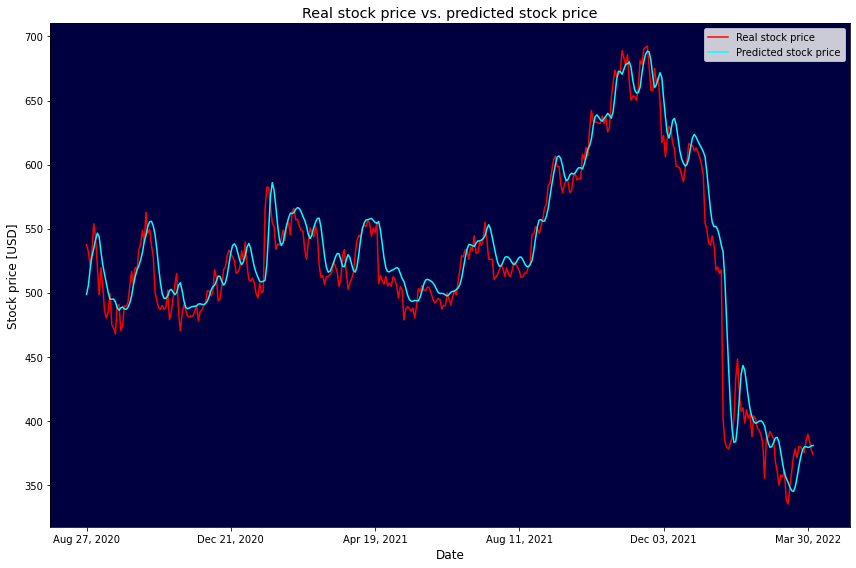

In [16]:
# Line plot of real stock prices vs. predicted stock prices
# Parameters, title and legend of the line plot

_, p = plt.subplots(figsize=(12,8))

p.plot(dates, real_prices, color='r', label='Real stock price')
p.plot(dates, predicted_prices, color='cyan', label='Predicted stock price')

p.set_title('Real stock price vs. predicted stock price', size='x-large')
p.set_ylabel('Stock price [USD]', size='large')
plt.xticks(np.arange(0, len(dates)+1, 80))
p.set_xlabel('Date', size='large')
p.set_facecolor('#000040')
p.legend()

plt.tight_layout()